# Day 18  Gaussian Mixture Models(GMM)

在实际应用中，k-means 的非概率性和它仅根据到簇中心点的距离来指派簇的特点将导致性能低下。
而高斯混合模型模型可以被看作是 k-means 思想的一个扩展

**混合模型（Mixture Model**

混合模型是一个可以用来表示在总体分布（distribution）中含有 K 个子分布的概率模型，换句话说，混合模型表示了观测数据在总体中的概率分布，它是一个由 K 个子分布组成的混合分布。混合模型不要求观测数据提供关于子分布的信息，来计算观测数据在总体分布中的概率。


In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

In [2]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1]

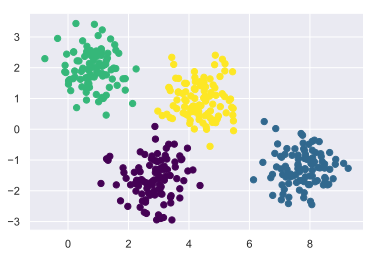

In [3]:
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

通过直接观察可以发现，某些点的归属簇比其他点的归属簇更加明确。例如，中间的两个簇似乎有一小块区域重合，而**k-means 模型本身也没有度量簇的分配概率或不确定性的方法**(虽然可以用数据 重抽样方法 bootstrap 来估计不确定性)。因此，我们必须找到一个更通用的模型。

理解 k-means 模型的一种方法是，它在每个簇的中心放置了一个圆圈(在更高维空间中是 一个超空间)，圆圈半径根据最远的点与簇中心点的距离算出

以用以下函 数将这个聚类模型可视化:

In [4]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
'''cdist:Compute distance between each pair of the two collections of inputs.'''

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # 画出输入数据
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2, alpha=0.3)
    
    centers = kmeans.cluster_centers_
    ax.scatter(centers[:, 0], centers[:, 1], c='red', alpha=1.0, s=200)
    
    # 画出k-means模型的表示
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

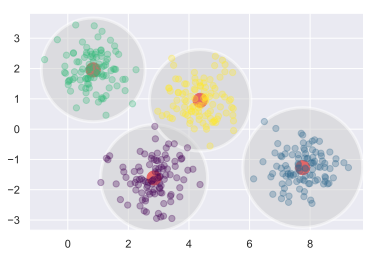

In [5]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

很明显, 因为k-means是由距离算出来的, 所以它有一个重要特征:

**它要求这些簇的模型必须是圆形:k-means 算法没有内置的方法 来实现椭圆形的簇**
<br>因此，如果对同样的数据进行一些转换，簇的分配就可能会变得混乱:

In [6]:
# kmeans = KMeans(n_clusters=4, random_state=0)
# plot_kmeans(kmeans, X)

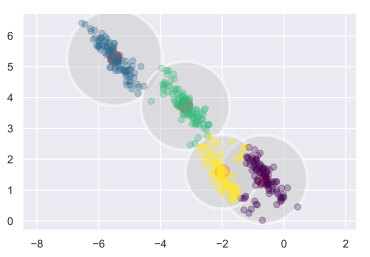

In [7]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

通过肉眼观察，可以发现这些变形的簇并不是圆形的，因此圆形的簇拟合效果非常糟糕。 

总之，k-means 对这个问题有点无能为力，只能强行将数据拟合至 4 个圆形的簇，但却导 致多个圆形的簇混在一起、相互重叠，右下部分尤其明显。

可以通过对 k-means 模型进行一般化处理来弥补这些不足，例如可以通过比较每个点 与所有簇中心点的距离来度量簇分配的不确定性，而不仅仅是关注最近的簇。你也可能想 通过将簇的边界由圆形放宽至椭圆形，从而得到非圆形的簇。实际上，这正是另一种的聚 类模型——高斯混合模型——的两个基本组成部分。

## 一般化E-M:高斯混合模型

一个高斯混合模型(Gaussian mixture model，GMM)**试图找到多维高斯概率分布的混合体，从而获得任意数据集最好的模型。**

在最简单的场景中，GMM 可以用与 k-means 相同的方式寻找类

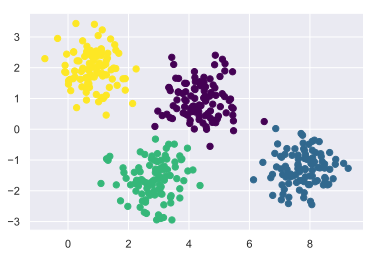

In [8]:
from sklearn.mixture import GaussianMixture # GMM Deprecated
# 连使用都是一样的! 
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

虽然"看起来"差不多, 但内核还是不同, 由于 GMM 有一个隐含的概率模型，因此它也可能**找到簇分配的概率结果**——在 Scikit- Learn中用**predict_proba**方法实现。

这个方法返回一个大小为[n_samples, n_clusters] 的矩阵，矩阵会给出任意点属于某个簇的概率:


In [9]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.531 0.469 0.    0.   ]
 [0.    0.    1.    0.   ]
 [0.    0.    1.    0.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    1.    0.   ]]


所以,我们可以将这个不确定性可视化，用每个点的大小体现预测的不确定性，使其成正比: 

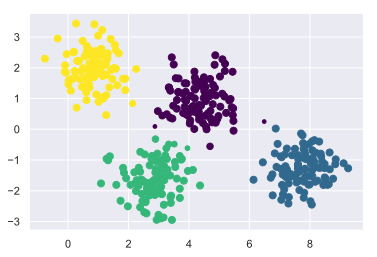

In [10]:
size = 50 * probs.max(1) ** 2 # 平方强调差异
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

**高斯混合模型本质上和 k-means 模型非常类似，它们都使用了期望最大化方法**，具体实现 如下。
1. 选择初始簇的中心位置和形状。 
2. 重复直至收敛。
    1. 期望步骤(E-step):为每个点找到对应每个簇的概率作为权重。
    2. 最大化步骤(M-step):更新每个簇的位置，将其标准化，并且基于所有数据点的权重来确定形状。

最终结果表明，每个簇的结果并不与**硬边缘的空间(hard-edged sphere)**???有关，而是通过高斯平滑模型实现。

正如在 k-means 中的期望最大化方法，这个算法**有时并不是全局最优解**， 因此在实际应用需要使用多个随机初始解。

下面创建一个可视化 GMM 簇位置和形状的函数，该函数用 gmm 的输出结果画出椭圆:

In [11]:
from matplotlib.patches import Ellipse
import warnings

warnings.filterwarnings(action='ignore')

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """用给定的位置和协方差画一个椭圆"""
    ax = ax or plt.gca()
    
    # 将协方差转换成主轴
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # 画出椭圆
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_): #covariances_ --> covars_
        draw_ellipse(pos, covar, alpha=w * w_factor)

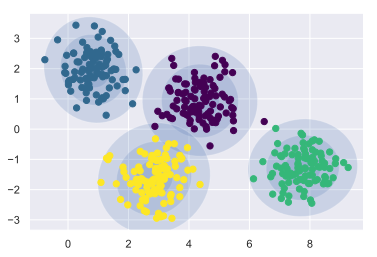

In [12]:
gmm = GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X)

同理，也可以用 GMM 方法来拟合扩展过的数据集。高斯模型允许使用全协方差(full covariance)，即使是于非常扁平的椭圆形的簇，该模型也可以处理:

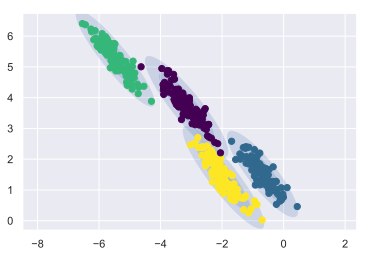

In [13]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

covariance_type 这个超参数控制了每个簇的形状自由度，其设置对任何问题都非常重要。

它的默认设 置是 covariance_type="diag"，意思是簇在每个维度的尺寸都可以单独设置，椭圆边界的 主轴与坐标轴平行。
<br>另一个更简单、更快的模型是 covariance_type="spherical"，该模型 通过约束簇的形状，让所有维度相等。
<br>还有一个更复杂、计算复杂度也更高的模型(特别适应于高 维度数据)是 covariance_type="full"，该模型允许每个簇在任意方向上用椭圆建模。